# MNIST digit classification

For detailed explanations, refer to:
* this [link](https://victorzhou.com/blog/keras-neural-network-tutorial/) for the MLP
* [here](https://victorzhou.com/blog/keras-cnn-tutorial/) for the simple CNN, and to this Kaggle [kernel](https://www.kaggle.com/anebzt/mnist-with-cnn-in-keras-detailed-explanation) for additional information on implementing CNN

On optimizing the CNN: 
this awesome Kaggle [kernel](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) and  
[Keras documentation](https://keras.io/examples/mnist_cnn/)

In [2]:
# import
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 9, 6
sns.set_style('white')

from random import randrange

In [3]:
# load data
data_set = pd.read_csv('./input/train.csv')
print(data_set.shape)

(42000, 785)


In [4]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
2395,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25144,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38906,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


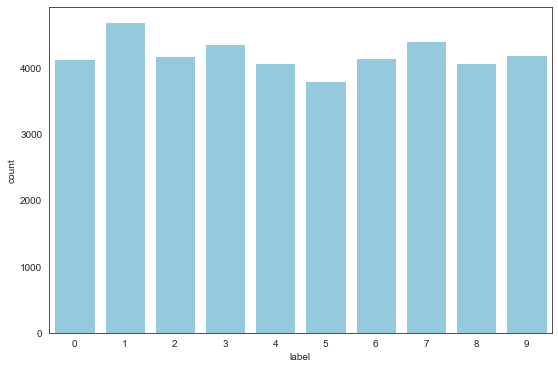

In [5]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

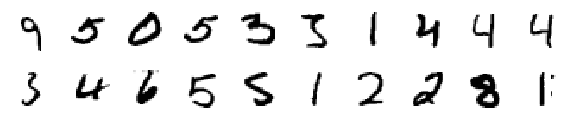

In [6]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(2, 10, figsize=(10, 2)) # 2 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [7]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)

## MLP

In [11]:
# define model
mlp = Sequential([
  Dense(128, activation='relu', input_shape=(784,)),  # change layer size from 64 to 128
  Dropout(0.25),
  Dense(64, activation='sigmoid'), # change activation function from relu to sigmoid
  Dropout(0.25),    
  Dense(10, activation='softmax'),
])

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model
n_epochs = 15 
validation_split = 0.05

#define callbacks
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=2)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Train on 39900 samples, validate on 2100 samples
Epoch 1/15
39900/39900 [==============================] - 27s 687us/step - loss: 0.5154 - acc: 0.8590 - val_loss: 0.2161 - val_acc: 0.9333
Epoch 2/15
39900/39900 [==============================] - 26s 655us/step - loss: 0.2248 - acc: 0.9352 - val_loss: 0.1631 - val_acc: 0.9467
Epoch 3/15
39900/39900 [==============================] - 26s 649us/step - loss: 0.1716 - acc: 0.9505 - val_loss: 0.1357 - val_acc: 0.9586
Epoch 4/15
39900/39900 [==============================] - 27s 684us/step - loss: 0.1392 - acc: 0.9586 - val_loss: 0.1319 - val_acc: 0.9581
Epoch 5/15
39900/39900 [==============================] - 27s 681us/step - loss: 0.1218 - acc: 0.9636 - val_loss: 0.1208 - val_acc: 0.9624
Epoch 6/15
39900/39900 [==============================] - 28s 701us/step - loss: 0.1076 - acc: 0.9673 - val_loss: 0.1095 - val_acc: 0.9638
Epoch 7/15
39900/39900 [==============================] - 26s 655us/step - loss: 0.0975 - acc: 0.9701 - val_loss: 0.1

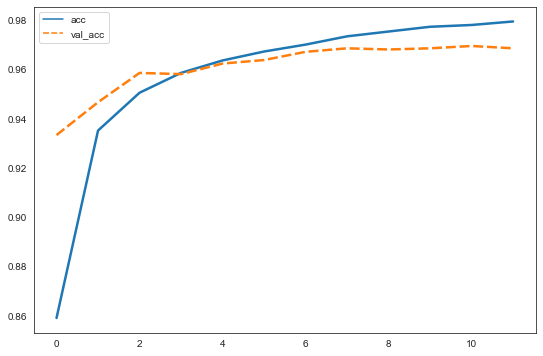

In [13]:
# load history in dataframe and plot accuracy of training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

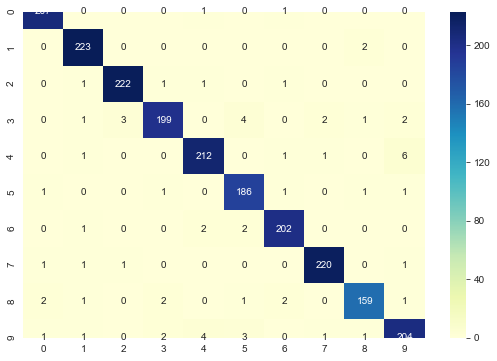

In [14]:
# get prediction on full dataset 
y_pred = mlp.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

confusion_mtx = confusion_matrix(y_val, y_pred)
sns.heatmap(data=confusion_mtx, annot=True, fmt='d', cmap='YlGnBu');

In [16]:
# save weights
mlp.save_weights('./output/mnist_mlp_dropout.h5')

# load test data
test = pd.read_csv('./input/test.csv')

# prediction
y_test = mlp.predict(test)

In [17]:
# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('./output/submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)

## Simple CNN

In [13]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1)

(42000, 28, 28, 1)


In [14]:
# define model
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),  
#  Dense(10, activation='sigmoid'),   
#  Dropout(0.25),     
  Dense(10, activation='softmax'),
])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [15]:
# Train the model
n_epochs = 10 # increase nbr of epochs from 5 to 10

history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_test, to_categorical(y_test)), 
    batch_size=64,
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 44s 1ms/step - loss: 0.4824 - acc: 0.8703 - val_loss: 0.2948 - val_acc: 0.9174
Epoch 2/10
37800/37800 [==============================] - 37s 991us/step - loss: 0.2403 - acc: 0.9319 - val_loss: 0.2342 - val_acc: 0.9319
Epoch 3/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.1865 - acc: 0.9484 - val_loss: 0.1901 - val_acc: 0.9455
Epoch 4/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.1519 - acc: 0.9574 - val_loss: 0.1715 - val_acc: 0.9531
Epoch 5/10
37800/37800 [==============================] - 40s 1ms/step - loss: 0.1276 - acc: 0.9641 - val_loss: 0.1483 - val_acc: 0.9571
Epoch 6/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.1105 - acc: 0.9693 - val_loss: 0.1391 - val_acc: 0.9586
Epoch 7/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0982 - acc: 0.9731 - val_loss: 0.1273 - val_ac

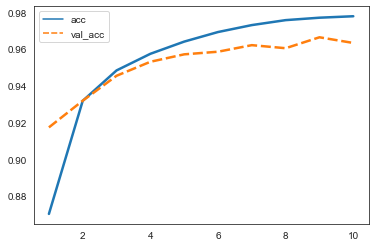

In [16]:
# load history in dataframe and plot accuracy for training and test data
df_history = pd.DataFrame(history.history, index=[i+1 for i in range(n_epochs)])  
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);